<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Volatility_calculation_and_black_scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install and import necessary libraries
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# VOLATILITY IS CALCULATED BY GETTING THE MEAN OF THE LOG OF TODAY'S PRICE COMPARED TO THE PREVIOUS DAY'S PRICE, GETTING THE MEAN LOG OF ALL THESE AND THE SUM OF VARIATIONS FROM THE MEAN WHICH IS USED TO CALCULATE THE STANDARD DEVIATIONS

In [ ]:

# 2. Download historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2024-01-01', end='2026-02-09')

/tmp/ipython-input-866697462.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2024-01-01', end='2026-02-09')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 3. Calculate Logarithmic Returns
# Log returns are preferred for statistical modeling in finance
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))

In [ ]:

# 4. Calculate Rolling Volatility
# window=21 represents roughly one trading month
# We multiply by sqrt(252) to annualize the daily standard deviation
window = 21
data['Volatility'] = data['Log_Ret'].rolling(window=window).std() * np.sqrt(252)

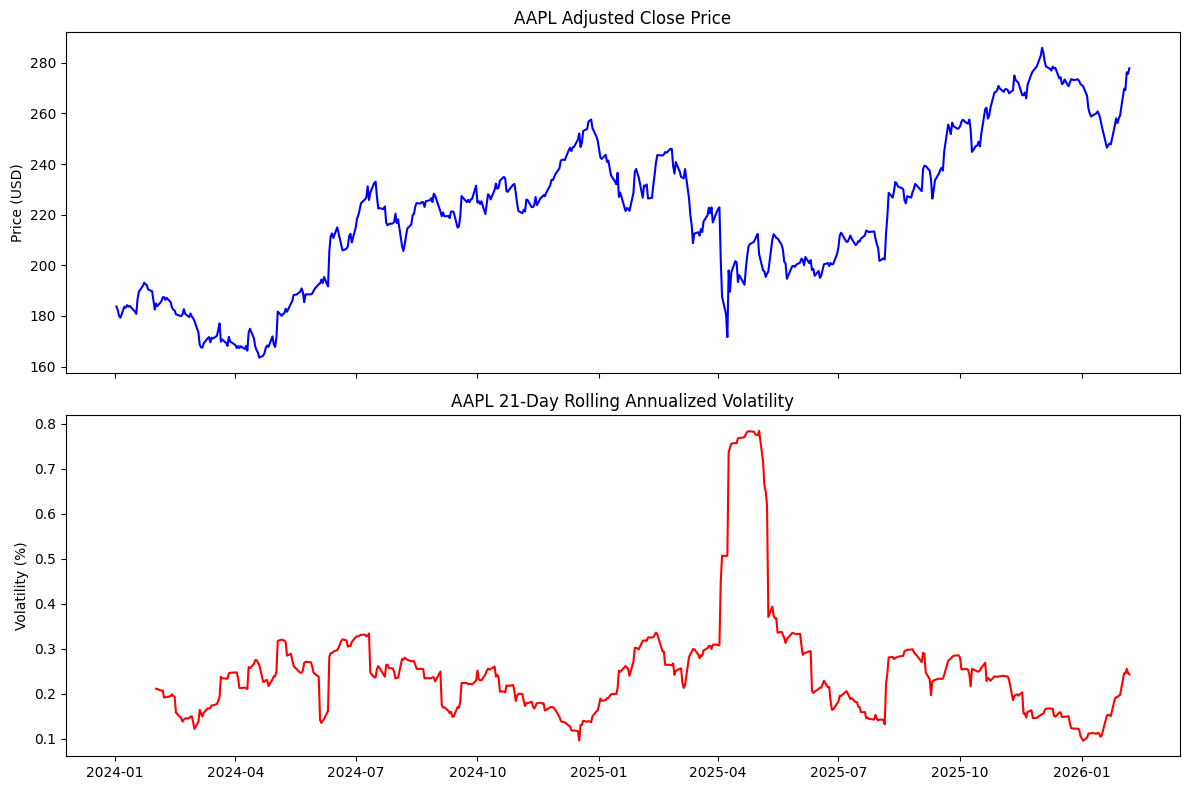

Current Annualized Volatility for AAPL: 24.31%


In [ ]:
# 5.Visualize close price against volatility
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Adjusted Close Price
ax[0].plot(data['Close'], color='blue')
ax[0].set_title(f'{ticker} Adjusted Close Price')
ax[0].set_ylabel('Price (USD)')

# Plot Annualized Volatility
ax[1].plot(data['Volatility'], color='red')
ax[1].set_title(f'{ticker} {window}-Day Rolling Annualized Volatility')
ax[1].set_ylabel('Volatility (%)')

plt.tight_layout()
plt.show()

# Print the most recent volatility value
current_vol = data['Volatility'].iloc[-1]
print(f"Current Annualized Volatility for {ticker}: {current_vol:.2%}")

VOLATILITY SURFACE
A volatility surface is a three-dimensional plot that illustrates how the implied volatility of options on a single underlying asset varies across both strike price (moneyness) and time to maturity (tenor).
If the standard Black-Scholes model assumptions were perfect, the surface would be flat. In reality, the surface is curved due to market factors:
Volatility Smile/Skew (X-Axis): Variations across strike prices. A "smile" shows higher volatility for both deep in-the-money (ITM) and out-of-the-money (OTM) options, while a "skew" (common in equities) shows higher volatility for OTM puts as investors seek crash protection.
Term Structure (Y-Axis): Variations across expiration dates, reflecting changing market expectations of volatility over time.


In [ ]:
# This cell contains Python import statements and no mathematical formulas to render.
# To make formulas readable, ensure they are in a Markdown cell using LaTeX syntax.
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [ ]:

# 1. Define the dimensions (Strikes and Maturities)
strikes = np.linspace(0.7, 1.3, 20)  # 70% to 130% moneyness
maturities = np.linspace(0.1, 2.0, 20)  # 1 month to 2 years
K, T = np.meshgrid(strikes, maturities)

In [ ]:

# 2. Simulate the components
# Smile: Parabolic shape centered at-the-money (K=1.0)
smile = 0.20 + 0.15 * (K - 1.0)**2

# Term Structure: Slight increase over time
term_structure = 0.05 * np.log(T + 0.1)

# 3. Combine to create the Surface (Implied Volatility Z)
iv_surface = smile + term_structure


In [ ]:

# 4. Plotly Interactive 3D Visualization
fig = go.Figure(data=[go.Surface(z=iv_surface, x=strikes, y=maturities, colorscale='Viridis')])
fig.update_layout(title='Simulated Volatility Surface',
                  scene=dict(xaxis_title='Moneyness (K/S)',
                             yaxis_title='Time to Maturity (Years)',
                             zaxis_title='Implied Volatility'))
fig.show()

implied volatility
Implied volatility is forward-looking and represents the market's expectation of future volatility. It cannot be calculated directly from past prices; instead, it is derived from options prices.
The Model: Analysts use options pricing models like Black-Scholes.
The Process: By taking the market price of an option and other known factors (current stock price, strike price, time to expiration, and risk-free interest rate), they "back out" the volatility value that makes the model's price match the actual market price.

In [ ]:
# deps
!pip install py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Inputs
market_price = 15.0  # Current price of the option in the market
S = 100.0           # Current stock price
K = 105.0           # Strike price
T = 0.5             # Time to expiration (6 months = 0.5 years)
r = 0.05            # Risk-free interest rate (5%)
flag = 'c'          # 'c' for call, 'p' for put

# Calculate IV
iv = implied_volatility(market_price, S, K, T, r, flag)

print(f"The Implied Volatility is: {iv:.2%}")


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62833 sha256=b6ce6b3e648330a8ad8bfcab637d8864551b960ea0a9e7476df8a9a2b099ad0f
  Stored in directory: /root/.cache/pip/wheels/5f/8c/ab/bbc3a2b0e6ae83633bb99f960459a2ab960b4672c7440ff4ef
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=671c4a6e95d7c40d7e6e9a91c6b99c868ce27c5120085717c9db8a277c89d6a8
  Stored in directory: /root/.cache/pip/wheels/c3/c6/50/415aabc2033e7651cc8cc590bd01c5f23f9050328f6016d6a5
Successfully built py_vollib py_lets_be_rational
The Implied Volatility is: 57.04%


In [ ]:
# manual calculation
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# 1. Standard Black-Scholes Formula
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# 2. Objective Function (Difference between market price and model price)
def objective_function(sigma, market_price, S, K, T, r, option_type):
    return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

# 3. Solver
def calculate_iv(market_price, S, K, T, r, option_type='call'):
    # We search for sigma between 0.001% and 500%
    return brentq(objective_function, 1e-6, 5.0, args=(market_price, S, K, T, r, option_type))

# Example usage for iv
mkt_val = 10.50
stock_price = 100
strike = 100
time = 1.0 # 1 year
rate = 0.03

iv_result = calculate_iv(mkt_val, stock_price, strike, time, rate)
print(f"Calculated IV: {iv_result:.2%}")


Calculated IV: 22.81%


In 2026, implied volatility (IV) remains a foundational tool for navigating complex market conditions characterized by elevated macro uncertainty and shifting global growth dynamics. It serves as a bridge between current asset prices and future market expectations, providing three primary applications:
1. Strategic Option Trading
Traders use IV to determine the relative "cost" of an option and select appropriate strategies based on whether they expect volatility to expand or contract.
Pricing Context: High IV means option premiums are expensive, favoring selling strategies like covered calls, credit spreads, or iron condors. Conversely, low IV makes options cheap, favoring buying strategies like long calls or puts and debit spreads.
Volatility "Crush" Trading: IV typically spikes ahead of binary events (e.g., corporate earnings, elections, or Federal Reserve meetings). Traders often sell options just before these events to profit from the rapid drop in IV—known as a "volatility crush"—once uncertainty is resolved.
Entry and Exit Timing: Identifying whether IV is high or low relative to its historical range (using IV Rank or IV Percentile) helps traders time entries for volatility-sensitive positions.
2. Risk Management and Probability Mapping
IV allows market participants to quantify the expected range of an asset's price movement, which is essential for managing downside risk.
Expected Move Calculation: Since IV is expressed as an annualized standard deviation, it can be scaled down to estimate a 1-standard deviation (68% probability) price range for specific timeframes. For example, if a stock at $100 has a 20% IV, the market implies a 68% chance it will stay between $80 and $120 over a year.
Hedging Decisions: Portfolio managers monitor the spread between IV and historical volatility (HV). If IV is significantly higher than HV, it may indicate a "volatility risk premium," suggesting that protection (puts) is expensive and may require more efficient hedging structures.
Greeks (Vega): IV is the primary input for Vega, the Greek that measures an option's sensitivity to changes in volatility. This helps traders manage the "volatility risk" of their entire portfolio.
3. Market Sentiment Indicator
Widely followed as a "fear gauge," IV provides real-time insights into collective investor anxiety.
Volatility Indices: The VIX (for the S&P 500) and India VIX (for the Nifty) track the aggregate IV of index options. Spikes in these indices typically signal rising fear and potential market corrections.
Cross-Market Warnings: In 2026, equity volatility is used as a leading indicator for other asset classes. For instance, sudden spikes in stock IV can trigger capital reallocations that strengthen "safe-haven" currencies like the US dollar or impact emerging market sentiment.
Volatility Skew: The difference in IV between various strike prices (skew) reveals where the market perceives the greatest threat. A "downside skew," where out-of-the-money puts have higher IV than calls, indicates that investors are more concerned about a price crash than a sudden rally.


In [ ]:
# black scholes

Imagine you have a "Magic Coupon" that lets you buy a rare Pokémon card for $10 exactly one month from today, no matter what the price is in the store.
The Black-Scholes Model is just a fancy math recipe to figure out exactly how many dollars that coupon should be worth today.
To get the price, the recipe looks at 5 things:
1. The Current Price (Where is it now?)
If the card is already selling for $20 in the store, your $10 coupon is very valuable! If it’s only selling for $2, your coupon isn’t worth much yet.
2. The Strike Price (Your special deal)
This is the $10 written on your coupon. The lower this number is, the better your deal, and the more the coupon costs.
3. Time (How long until it expires?)
If your coupon expires in an hour, there isn't much time for the price to change. But if it expires in a year, there’s a big chance the card could become super expensive. More time = a more expensive coupon.
4. Volatility (How "wiggly" is the price?)
This is the most important part.
If the card price stays at $10 every single day, the coupon is boring.
If the price jumps to $50 one day and $1 the next, the coupon is exciting because you might get a huge bargain.
The more "wiggly" (volatile) the price is, the more the coupon costs.
5. The Interest Rate (The "Waiting" Cost)
Since you are waiting a month to buy the card, you can keep your money in a piggy bank for now. This tiny bit of extra savings makes the coupon worth just a little bit more.
In a nutshell:
The Black-Scholes model is like a calculator for a fair trade. It says: "Based on how much the price wiggles and how much time is left, here is the fair amount of money you should pay for this 'maybe' deal."


In [ ]:
import numpy as np
from scipy.stats import norm

def calculate_greeks(S, K, T, r, sigma, option_type='call'):
    """
    S: Spot Price, K: Strike Price, T: Time to Maturity (Years),
    r: Risk-free Rate, sigma: Volatility (decimal)
    """
    # Intermediate calculations
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Standard Normal PDF and CDF
    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)

    # --- Price ---
    if option_type == 'call':
        price = S * cdf_d1 - K * np.exp(-r * T) * cdf_d2
        delta = cdf_d1
        rho = (K * T * np.exp(-r * T) * cdf_d2) / 100
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * cdf_d2) / 365
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = cdf_d1 - 1
        rho = (-K * T * np.exp(-r * T) * norm.cdf(-d2)) / 100
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365

    # --- Common Greeks (Same for Call/Put) ---
    gamma = pdf_d1 / (S * sigma * np.sqrt(T))
    # Vega: Change in price for a 1% (0.01) change in sigma
    vega = (S * np.sqrt(T) * pdf_d1) / 100

    return {
        "Price": price, "Delta": delta, "Gamma": gamma,
        "Vega (1% Vol change)": vega, "Theta (1 Day)": theta, "Rho": rho
    }

# Example Usage
params = {"S": 100, "K": 105, "T": 0.5, "r": 0.05, "sigma": 0.25}
greeks = calculate_greeks(**params)

print(f"Option Results for {params['S']} Strike {params['K']}:")
for key, value in greeks.items():
    print(f"{key:20}: {value:.4f}")


Option Results for 100 Strike 105:
Price               : 5.9885
Delta               : 0.4816
Gamma               : 0.0225
Vega (1% Vol change): 0.2818
Theta (1 Day)       : -0.0251
Rho                 : 0.2108


The Formula The price of a Call option (\(C\)) is determined by: \(C=S_{t}N(d_{1})-Ke^{-rT}N(d_{2})\)Where: \(N(\cdot )\): The cumulative distribution function of the standard normal distribution (the probability that a random variable is less than or equal to a certain value).\(d_{1}=\frac{\ln (S/K)+(r+\sigma ^{2}/2)T}{\sigma \sqrt{T}}\)\(d_{2}=d_{1}-\sigma \sqrt{T}\) \\